In [39]:
# Import all dependencies
import numpy as np
import random as rd
import pandas as pd
import math
import re
from scipy.stats import norm
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1: Simulate Rankings of Relevance for E and P

In [40]:
def simulate_rankings():
    ''' This method creates all possible combinations of rankings for P and E.

        @Output: a list of tuples. A tuple has 2 integer arrays (one ranking for P and one for E).
    '''
    P = [[0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, 1],
         [1, 0, 1], [0, 1, 1], [0, 0, 1], [0, 1, 0]]
    E = [[0, 0, 0], [1, 0, 0], [1, 1, 0], [1, 1, 1],
         [1, 0, 1], [0, 1, 1], [0, 0, 1], [0, 1, 0]]
    rankings = []

    for p in P:
        for e in E:
            tup1 = (p, e)
            rankings.append(tup1)

    print(rankings)
    return rankings


rankings = simulate_rankings()

[([0, 0, 0], [0, 0, 0]), ([0, 0, 0], [1, 0, 0]), ([0, 0, 0], [1, 1, 0]), ([0, 0, 0], [1, 1, 1]), ([0, 0, 0], [1, 0, 1]), ([0, 0, 0], [0, 1, 1]), ([0, 0, 0], [0, 0, 1]), ([0, 0, 0], [0, 1, 0]), ([1, 0, 0], [0, 0, 0]), ([1, 0, 0], [1, 0, 0]), ([1, 0, 0], [1, 1, 0]), ([1, 0, 0], [1, 1, 1]), ([1, 0, 0], [1, 0, 1]), ([1, 0, 0], [0, 1, 1]), ([1, 0, 0], [0, 0, 1]), ([1, 0, 0], [0, 1, 0]), ([1, 1, 0], [0, 0, 0]), ([1, 1, 0], [1, 0, 0]), ([1, 1, 0], [1, 1, 0]), ([1, 1, 0], [1, 1, 1]), ([1, 1, 0], [1, 0, 1]), ([1, 1, 0], [0, 1, 1]), ([1, 1, 0], [0, 0, 1]), ([1, 1, 0], [0, 1, 0]), ([1, 1, 1], [0, 0, 0]), ([1, 1, 1], [1, 0, 0]), ([1, 1, 1], [1, 1, 0]), ([1, 1, 1], [1, 1, 1]), ([1, 1, 1], [1, 0, 1]), ([1, 1, 1], [0, 1, 1]), ([1, 1, 1], [0, 0, 1]), ([1, 1, 1], [0, 1, 0]), ([1, 0, 1], [0, 0, 0]), ([1, 0, 1], [1, 0, 0]), ([1, 0, 1], [1, 1, 0]), ([1, 0, 1], [1, 1, 1]), ([1, 0, 1], [1, 0, 1]), ([1, 0, 1], [0, 1, 1]), ([1, 0, 1], [0, 0, 1]), ([1, 0, 1], [0, 1, 0]), ([0, 1, 1], [0, 0, 0]), ([0, 1, 1], [1,

### Step 2: Calculate the $\Delta$ measure

We calculate the Expected reciprocal rank of a ranking using the guy 

ERR := $\sum_{r = 1}^n \frac{1}{r}$ P(user stops at position r)

where n is the number of documents in the ranking and

$P = \prod_{i=1}^{r-1} (1-R_i)R_r$

where $R_i = \frac{2^g - 1}{2^{g_{max}}}$ where $g_i$ is the grade of the i-th document and $g_{max}$ is the the maximum relevance.

In [41]:
def calculate_ERR(ranking):
    ''' This method calculates the ERR of a ranking. A ranking is a one dimensional interger list with length 3.

        @Input: a one dimensional list of length 3 with zeros and ones.

        @Output: a double (ERR score).
    '''
    ERR = 0
    for r in range(len(ranking)):
        prob_to_stop_at_r = ranking[r]/(r+1)/2
        for i in range(r):
            prob_to_stop_at_r *= 1 - ranking[i]/2

        ERR += prob_to_stop_at_r

    return ERR

The buckets are made such that group 1 contains all pairs for which 0.05 < $\Delta$ measure ≤ 0.1, group 2 all pairs for which 0.1 < $\Delta$measure ≤ 0.2, etc.

In [42]:
def calculate_Dmeasures(rankings):
    ''' This method calculates the difference in ERR between the two rankings of every tuple, 
        for all tuples of rankings.
        Since we need to store the results in 10 different buckets we use a dictionary with keys 10 integers 
        from 0 to 9 with step 1 and values the list of our measurements.

        @Input: a list of tuples.

        @Output: A dictionary with keys integers from 0 to 9 and values 10 lists of doubles. 
    '''
    measures = {k: [] for k in range(10)}

    # The indices in measures are now the indices of the pair tuples
    for index, r in enumerate(rankings):
        ERR_P = calculate_ERR(r[0])
        ERR_E = calculate_ERR(r[1])

        d_measure = ERR_E - ERR_P
        if d_measure >= 0.05 and d_measure <= 0.95:
            measures[int(d_measure * 10)].append(index)

    return measures


### Step 3: Implement Team-Draft Interleaving and Probabilistic Intearleaving

In [43]:
def convert_lists_to_labeled(list_a, list_b):
    ''' Give the ranking lists of documents
    '''
    considered_lists = [deepcopy(list_a), deepcopy(list_b)]
    label_results = []
    # set_trace()

    for doc_list in considered_lists:
        possible_labels = rd.sample(range(1, 20), 3)
        label_results.append(list(zip(doc_list, possible_labels)))

    return label_results


def team_draft_interleaving(list_a, list_b):
    ''' Team draft interleaving is performed by throwing a coin. If its heads we put in the interleaved list
        the first element of list A that is not already in,
        if its tails we put in the interleaved list the first element of list B that is not already in.

        @Input: 2 lists of integers of length 3.

        @Output: an interleaved list of tuples of length 3. Each tuple contain an integer (document ID) and a 0 or 1 
        depending of which list it came from.
    '''

    unique_doc_list = []
    interleaved_list = []
    counter = 0
    list_a_labeled, list_b_labeled = convert_lists_to_labeled(
        deepcopy(list_a), deepcopy(list_b))

    while counter < 3:
        coin_toss = rd.random()

        if(coin_toss > 0.5):
            put_first_available_url_in_interleaved(
                list_a_labeled, 0, interleaved_list, unique_doc_list)
            counter += 1

            if(counter == 3):
                return interleaved_list

            put_first_available_url_in_interleaved(
                list_b_labeled, 1, interleaved_list, unique_doc_list)
            counter += 1
        else:
            put_first_available_url_in_interleaved(
                list_b_labeled, 1, interleaved_list, unique_doc_list)
            counter += 1
            if(counter == 3):
                return interleaved_list

            put_first_available_url_in_interleaved(
                list_a_labeled, 0, interleaved_list, unique_doc_list)
            counter += 1

    print("List is:", interleaved_list)
    return interleaved_list


def put_first_available_url_in_interleaved(a_list, index_list, interleaved_list, unique_doc_list):
    ''' Helper method that creates a tuple with and integer (document ID) and 
        a 0 or 1 which indicates from which list it came from and adds it in the interleaved list. 

        @Input: - a list of intergers of length 3.
                - a 0 or 1 indicator of the list.
                - the interleaved list with all tuples of rnakings.

    '''

    for i in a_list:
        if i[1] not in unique_doc_list:
            interleaved_list.append((i[0], index_list))
            unique_doc_list.append(i[1])
            return


In [44]:
team_draft_interleaving(rankings[0][0], rankings[0][1])

[(0, 1), (0, 0), (0, 1)]

$\textbf{Probabilistic Intearleaving}$ is performed similarly but instead of choosing the first document we chose the documents from the lists probabilisticly where the probabilities of the documents are produced from 2 softmax functions
(one for every list).

In [45]:
def probabilistic_interleaving(list_a, list_b):
    ''' Probabilistic interleaving perfromed by throwing coins, if its heads we use the softmax function of list A
        to choose randomly (with higher probability the more relevant rankings)
        else we use the softmax function of list B. 
        After we put the choosen doc we remove it from both lists A and B softmaxes.
        We do this until the interleaved list is full.
        The interleaved list contains tuples with the document ID and a 0 or 1 considering the list that it came from.

        @Input: 2 lists of integers of length 3.

        @Output: an interleaved list of tuples of length 3. Each tuple contain an integer (document ID) and a 0 or 1 
        depending of which list it came from.

    '''
    interleaved_list = [ ]
    counter = 0
    list_a, list_b = deepcopy(list_a), deepcopy(list_b)
    while counter < 3:
        coin_toss = rd.random()
        if len(list_a+list_b) == 0:
            raise InvalidArgumentError
        if(coin_toss > 0.5):
            if len(list_a) == 0:
                continue
            probs = softmax(list_a)
            chosen = np.random.choice(list_a, 1, p = probs)
            tup = (int(chosen), 0)
            interleaved_list.append(tup)
               
        else:
            if len(list_b) == 0:
                continue
            probs = softmax(list_b)
            chosen = np.random.choice(list_b, 1, p = probs)
            tup = (int(chosen), 1)
            interleaved_list.append(tup)
      
        counter += 1  
        if chosen in list_a: 
            list_a.remove(chosen)
            
        if chosen in list_b: 
            list_b.remove(chosen)
            
    return interleaved_list
    


def softmax(a_list, tau=3):
    ''' Helper method that calculates the probabilities of every document in the given list
        using the softmax function in a vectorised from.

        @Input: list of intergers of length 3 (rankings).

        @Output: a vector with probabilities for every document.
    '''
    rankings = []
    for i,doc in enumerate(a_list):
        rankings.append(i+1)
    
    numerators = 1 / np.power(rankings, tau)
 
    denominator = numerators.sum()
   
    return numerators / denominator


### Step 4: Implement Click-based models


#### Position Based Model} (PBM) is expressed with the equations bellow:

$P(E_{r_u} = 1) = \gamma_{r_u}$

$P(A_u = 1) = \alpha_{uq}$

$P(C_u =1) = P(E_{r_u} = 1) \cdot P(A_u = 1)$


The parameters of PBM can be estimated based on the Expectation-Maximization (EM) method:

  * Set parameters to some initial values
  * Repeat until convergence:
      * E-step: derive the expectation of the likelihood function.
      * M-step: maximize this expectation.


We update the attractiveness with the formula:

$\alpha^{(t+1)} =  \frac{1}{|S_{uq}|} \sum_{s\in S_{uq}}\bigg(c^{(s)}_{u} +(1 - c^{(s)}_{u}) \frac{(1 - \gamma^{(t)}_r) \alpha^{(t)}_{uq}}{1 -\gamma^{(t)}_r \alpha^{(t)}_{uq}} \bigg)$

and the examination with the formula:

$\gamma^{(t+1)}_r = \frac{1}{|S|} \sum_{s\in S_{uq}}\bigg(c^{(s)}_{u} + (1 - c^{(s)}_{u}) \frac{( \gamma^{(t)}_r)(1 - \alpha^{(t)}_{uq})}{1 -\gamma^{(t)}_r \alpha^{(t)}_{uq}} \bigg)$

#### Random Click Model}(RCM) is expressed with the equation bellow:

$P(C_u =1) = const = \rho$

Where $E_r$ stands for Examination which is a binary random variable denoting examination of a snippet at rank r. $A_u$ stands for Attractiveness (a user wants to click on a document after examining its snippet) and is also a binary random variable showing whether document u is attractive to user, given query q. Finally $C_u$ again a binary random variable denoting a click on document u.

In [46]:
class YandexData():
    """
        The structure of lookup table:
        {
            'q_id':{
                'sessions':[
                {
                    'url_ids':[],
                    'clicks':[]
                }
                ]
                'docs':set([])
            }
        }

        @Properties:        
            - `q_id` is the id of the different queries, key to object:
                - `session` is a list of the sessions of this particular `q_id`
                    each `session` have a list of `url_ids` and a `clicks` list, 
                    the url in `clicks` must be in the `url_ids`
                - `docs` is the union of all urls returned by the system per query
    """

    def __init__(self, path):
        self.path = path
        self._load_data()

    def _load_data(self):
        CUTOFF = 3
        queries_lookup = {}

        # Lambda functions
        def new_item(): return {'sessions': [], 'docs': set()}

        def turn2int(x): return [int(i) for i in x]

        with open(self.path, 'r') as f:
            click = []
            last_q = None

            for line in f.readlines():
                vals = re.split(r'\t+', line.rstrip())

                # If line is a query
                if vals[2] == 'Q':
                    current_q = vals[3]

                    # Get the relevant URLs
                    cutoff_urls = turn2int(vals[5:5 + CUTOFF])

                    if current_q not in queries_lookup.keys():
                        it = new_item()
                    else:
                        it = queries_lookup[current_q]

                    # Append documents for this query and add session
                    it['docs'] = it['docs'].union(cutoff_urls)
                    it['sessions'].append({'urls': cutoff_urls, 'clicks': []})

                    queries_lookup[current_q] = it
                    last_q = current_q

                # Else if line is a click
                elif vals[2] == 'C':
                    # If the document has been found in the active query, add
                    # the document to the selection of clicks
                    if int(vals[3]) in queries_lookup[last_q]['sessions'][-1]['urls']:
                        queries_lookup[last_q][
                            'sessions'][-1]['clicks'].append(int(vals[3]))

        self.queries_lookup = queries_lookup

In [47]:
class ClickModel(object):
    def __init__(self):
        pass

    def train(self, data):
        raise NotImplementedError

    def get_probs(self, rankings):
        raise NotImplementedError

    def is_click(self, rankings, epsilon=0.1):
        """
            simulate the click, return a boolean list of the same length as `rankings`, True means clicked
        """
        probs = self.get_probs(rankings, epsilon)

        def click_fn(p): return rd.uniform(0, 1) < p
        return list(map(click_fn, probs))

In [48]:
class PBM(ClickModel):
    def __init__(self):
        super(PBM, self).__init__()
        self.alpha_uq = {}
        self.gamma_r = [rd.uniform(0, 1) for _ in range(CUTOFF)]

    def train(self, data, T=20, load=False):
        """ Trains the parameters of the model according to the data.

            @Input:
                - data: YandexData object, Yandex data
                - T: integer, time steps of the training loop
                - load: boolean, whether trained gamma is used (we dont need trained alpha because during inference they are replaced by epsilon)
        """

        if load:
            self.gamma_r = [0.9998564405092062,
                            0.48278049975990095, 0.3335993103977007]
            return

        self._init_alpha(data)

        for _ in range(T):
            self._update_alpha(data)
            self._update_gamma(data)

    def _init_alpha(self, data):
        """ Initializes alpha on the model to be a dictionary only where (query, doc) have a value

            @Input:
                - data: YandexData object
        """
        for q, it in data.queries_lookup.items():
            for doc in it['docs']:
                self.alpha_uq[(q, doc)] = rd.uniform(0, 1)

    def _update_alpha(self, data):
        """ Performs an update of alpha in EM

            @Input:
                - data: YandexData object
        """

        # Get all the sessions and docs belonging to a query.
        ql = data.queries_lookup
        new_alpha_uq = deepcopy(self.alpha_uq)

        # Loop through all query-doc combos
        for (q, u), alpha in self.alpha_uq.items():
            count = 2
            contribution_sum = 1

            for sess in ql[q]['sessions']:
                if u not in sess['urls']:
                    continue

                count += 1
                if u in sess['clicks']:
                    contribution_sum += 1
                else:
                    ind = sess['urls'].index(u)
                    contribution_sum += (1 - self.gamma_r[ind]) * \
                        alpha / (1 - self.gamma_r[ind] * alpha)

            new_alpha_uq[(q, u)] = contribution_sum / count

        self.alpha_uq = new_alpha_uq

    def _update_gamma(self, data):
        """ Performs an update of gamma in EM

            @Input:
                - data: YandexData object
        """

        ql = data.queries_lookup
        sess_num = 0
        contrib_sum = [0] * CUTOFF
        for q, item in ql.items():
            sess_num += len(item['sessions'])
            for sess in item['sessions']:
                for i, u in enumerate(sess['urls']):
                    if u in sess['clicks']:
                        contrib_sum[i] += 1
                    else:
                        contrib_sum[i] += self.gamma_r[i] * (1 - self.alpha_uq[q, u]) / (
                            1 - self.gamma_r[i] * self.alpha_uq[q, u])

        self.gamma_r = [i / sess_num for i in contrib_sum]
        return

    def get_probs(self, rankings, epsilon=0.1):
        """
            assume `rankings` are list of relevance labels
            use `epsilon` to substitute alpha, typical value is 0.1
        """
        def prob_fn(args): return self.gamma_r[
            args[0]] * (1 - epsilon if args[1] == 1 else epsilon)
        return list(map(prob_fn, enumerate(rankings)))


In [49]:
CUTOFF = 3


class RCM(ClickModel):
    """
        Random clicking model
    """

    def __init__(self):
        super(RCM, self).__init__()
        self.gamma = [0] * 3

    def train(self, data, load=True):
        """
            get the \rho paramter for random clicking by calculating the fraction of clicked urls among all returned results
        """
        if load:
            self.rho = 0.2802838475726031
            return
        sess_num = 0
        cli_num = 0
        for q, it in data.queries_lookup.items():
            for sess in it['sessions']:
                cli_num += len(sess['clicks'])
            sess_num += len(it['sessions'])
        self.rho = cli_num / sess_num / CUTOFF
        return

    def get_probs(self, rankings, epsilon=None):
        """
            return \rho list regardless
        """
        return [self.rho] * len(rankings)


### Step 5: Simulate Interleaving Experiment

With the click models developed, it will be possible to simulate an online experiment. The general flow will start with initializing a click model, and training it to learn the gamma values (for PBM) or the rho (for RCM). For PBM, epsilon values will be used as alpha proxy. The data from Yandex will be used to train the models using Expectation Maximization. These models will then serve in the online experiments to simulate clicks.

The goal is to run a number of `k` competitions of our rankers E and P. For each competition, their rankings will be interleaved, and according to the used model, clicks for their rankings will be simulated. The ranker with the largest number of clicks win the round. This is repeated k times, after which the number of times E wins out of all victory games is used as the main proportion.

In [50]:
# Import the appropriate data
yd = YandexData('./YandexRelPredChallenge.txt')

# Training the PBM and RCM model
model_PBM = PBM()
model_PBM.train(yd, 100, True)
model_RCM = RCM()
model_RCM.train(yd, True)

In [52]:
def simulate_experiment(rankingA, rankingB, model, interleave_fn=team_draft_interleaving, k=100):
    ''' Simulate an online experiment using a given `interleave_fn`, click `model`, and two lists.
    
        @Input:
            - rankingA: a list of relevance labels
            - rankingB: a list of relevance labels
            - model: a click model, like PBM and RCM
            - interleave_fn: an interleave function, like team-draft and probabilsitic
            - k: number of times to put two ranker-lists against another
            
        @Output:
            - Proportion of wins of E vs P
    '''
    
    E_wins = 0
    P_wins = 0

    for i in range(k):
        E_clicks = 0
        P_clicks = 0
        new_results_w_models = interleave_fn(rankingA, rankingB)
        new_results_relevance = [i[0] for i in new_results_w_models]
        ranker_clicked = [i[1] for i in new_results_w_models]
        clicks = model.is_click(rankings=new_results_relevance, epsilon=0.1)

        for index, click in enumerate(clicks):
            if click:
                if ranker_clicked[index] == 1:
                    E_clicks += 1
                else:
                    P_clicks += 1

        if E_clicks > P_clicks:
            E_wins += 1
        elif P_clicks > E_clicks:
            P_wins += 1

    return (E_wins + 1) / (E_wins + P_wins + 1)


### Step 6: Estimate sample size

We allow a chance of falsely rejecting the null hypothesis (i.e. concluding that E is better than P, when it is not) of 5\% and a chance of falsely not rejecting the null hypothesis (i.e. not concluding that E is better than P, when it is) of 10\%.

We use the proportion p of wins for E against P for determining the number of required impressions using the proportion test. Assuming that the sampling distribution for proportions can be approximated by a normal distribution we use the following equation to compute the minimum sample size.

$N' \geq \bigg( \frac{z_1-\alpha \sqrt{p_0(1-p_0)} +z_1 -\beta \sqrt{p_1(1-p_1)}}{\delta} \bigg)^2 $

where $p_0 = 0.5$ since each system wins 50\% of the times and $p_1$ is the proportion of times E wins over P out of k simulations. $\alpha$ and $\beta$ specify the level of significance. We set $\alpha = 0.05$ , $\beta = 0.1$ , $\delta = |p_0 -p_1|$ and z is the standard normal distribution.

Finally, using the continuity correction the minimum sample size is determined as $N = N' + \frac{1}{\delta}$.

In [66]:
def calc_sample_size(p_val, alpha=0.05, beta=0.10, p_null=0.5):
    ''' Calculate the sample size given a p-val according to a one-tailed statistical test.
    
        @Input:
            -p_val: a p-value used to calculate an N high enough for statistical significance.
    '''
    z = norm.ppf(1-alpha)*math.sqrt(p_null * (1 - p_null)) + \
        norm.ppf(1-beta) * math.sqrt(p_val * (1-p_val))

    if p_val == p_null:
        return math.inf

    if z == 0.0:
        return -1

    return ((z/(abs(p_val-p_null)))**2) + 1/abs(p_val-p_null)

def calc_sample_size_for_bins(interleave_fn=team_draft_interleaving, model=model_PBM, rankings=rankings):
    ''' Given an interleaving technique, model and simulated rankings, calculate the bins according to the offline
        evaluation (Δ M), and then calculate the sample size for each bin. Each sample size will be represented by 
        the min, median and maximum.
        
        @Output: a table with all the minimum, maximum and median sample size required.
    '''
    
    bins = calculate_Dmeasures(rankings)
    bin_vals = list(bins.keys())
    table = pd.DataFrame(index=bin_vals,columns=['minimum', 'median', 'maximum'])    

    for bin_key, bin_el in bins.items():
        minimum, median, maximum = calc_sample_size_for_bin(bin_el, interleave_fn, model)
        table.loc[bin_key]['minimum'] = minimum
        table.loc[bin_key]['median'] = median
        table.loc[bin_key]['maximum'] = maximum
    
    return table


def calc_sample_size_for_bin(binned_el, interleave_fn, model):
    ''' Given a particular bin, calculate the sample size needed to calculate a statistical significant appearance of the
        effect size implicated by the underlying bin. 
        
        @Input:
            - binned_el: a grouping of pairs based on offline evaluation effect sizes.
            - interleave_fn: interleave function
            - model: click-based model
            
        @Output:
            - A tuple of minimum, median and maximum of required sample size
    '''
    
    result = []

    for pair in binned_el:
        pairE = rankings[pair][0]
        pairP = rankings[pair][1]
        proportion_E_win = simulate_experiment(pairE, pairP, model, interleave_fn)
        sample_size = calc_sample_size(proportion_E_win)

        if sample_size >= 0:
            result.append(calc_sample_size(proportion_E_win))

    if len(binned_el) > 0:
        maximum = np.max(result)
        minimum = np.min(result)
        median = np.median(result)

        return (minimum, median, maximum)
    
    return math.inf, math.inf, math.inf

### Step 7: Analysis

With the online and offline analysi, it should now be possible to run each model and interleaving technique and examine the results. Due to the high varying nature of these methods, each of the model-technique pairs will be plotted 4 times to show the variance, along with the table to show each bin along with its required sample size.

In [145]:
def run_setup(model, method):
    ''' Given a model and method, calculate sample size for bins of the simulated rankings calculated during step 1.
    
        - Print table displaying the minium, median and maximum
        - Plot each of the resulting bins along with their required sample size 4 times to show variance.
    '''
    table_setup = calc_sample_size_for_bins(interleave_fn=method, model=model)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    fig.suptitle('4 sample runs of {}_{}'.format(model.__class__.__name__, method.__name__))
    plot_title = '{}_{}'.format(model.__class__.__name__, method.__name__)
    
    print(table_setup)
    
    for i, ax in enumerate(axes.flatten()):    
        table_setup.plot.bar(title=plot_title, ax=ax)
        table_setup = calc_sample_size_for_bins(interleave_fn=method, model=model)
    
def run_all_setups(models=[model_PBM, model_RCM], methods=[team_draft_interleaving, probabilistic_interleaving]):
    for model in models:
        for method in methods:
            run_setup(model, method)

#### Team-draft PBM 

   minimum   median  maximum
0  52.6586  570.345  14474.1
1  12.2151  84.6903     1132
2  12.4968   14.189  26.6713
3  8.70421  13.3218  17.6005
4  7.78945  7.94379  20.4892
5  4.70554  5.98919  9.63311
6  6.81702  8.09473  9.37244
7      inf      inf      inf
8      inf      inf      inf
9      inf      inf      inf


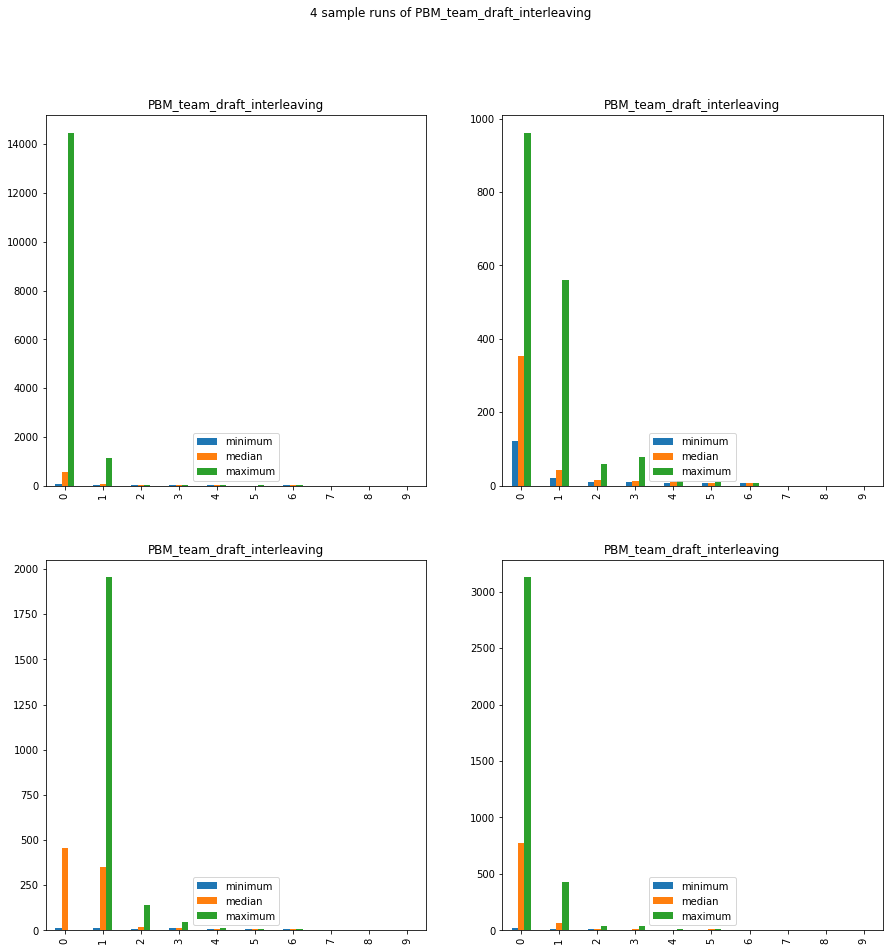

In [146]:
run_setup(model_PBM, team_draft_interleaving)

On average, the PBM team-draft shows a strong tendency to decrease along with the x-axis of the above plot. Most strongly, this can be found reflected in all of the dercreasing statistics (median, minimum and maximum). While an outlier might skew the results to seem less descending, as the maximum and minimum reach a strong decrease after approximately bin 2, it can be inferred that the larger the effect size is in ΔM, and as the proportional difference in victories increases, so does the required number of sample size decrease.

#### Probabilistic Interleaving PBM

   minimum   median  maximum
0  43.2096   121.46  492.957
1  26.0475  70.5949   134.27
2  24.0397  43.8389  51.5182
3  15.0529  20.6787  25.3457
4  11.7166  19.0826  24.2613
5  11.0973  12.8042  15.0529
6  9.49847  11.7927  14.0869
7      inf      inf      inf
8      inf      inf      inf
9      inf      inf      inf


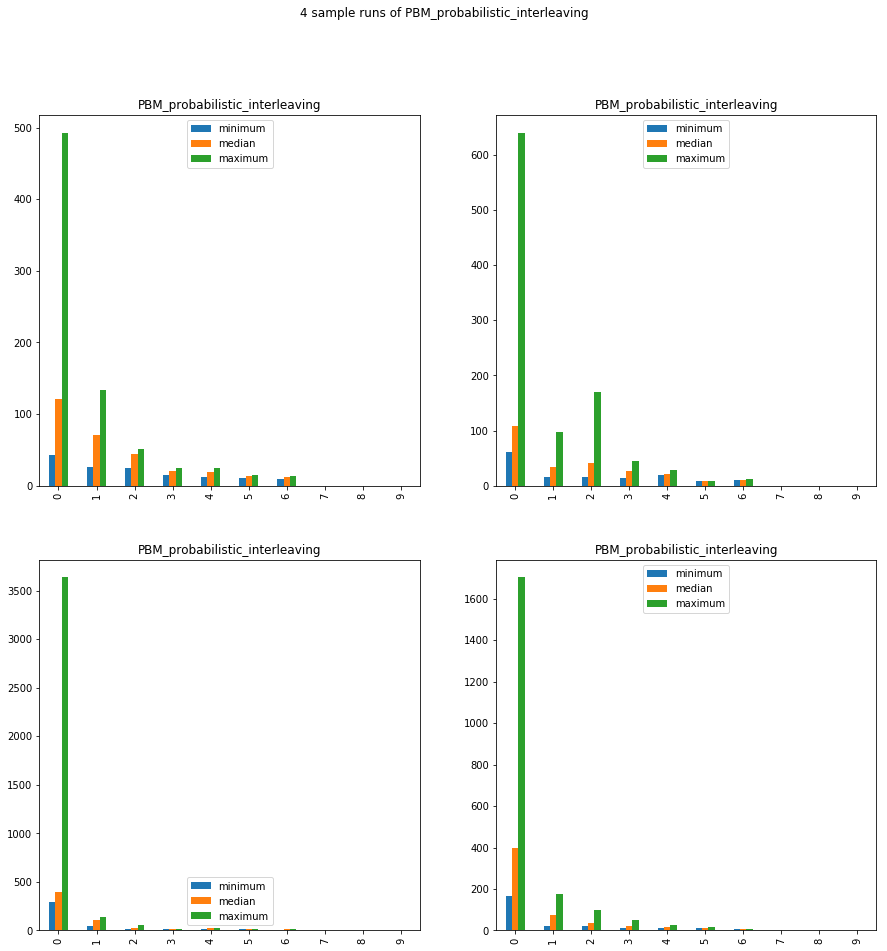

In [147]:
run_setup(model_PBM, probabilistic_interleaving)

Similar to team-draft, probabilistic interleaving shows an almost smooth descent in sample size needed, except the bins with the smallest effect size (leftmost on the axis) on average display lower rankings and thus, the difference between the bins seem less extreme initially. The differences become less extreme, resembling those of the team-draft PBM.

#### Team-draft RCM

   minimum   median  maximum
0  132.555  798.351   3125.8
1  100.499  429.867  1702.76
2  125.417  2809.49  27934.2
3  304.998  6293.29  24158.1
4  203.137  429.867  907.627
5  68.3928  220.324  240.224
6  290.876  635.277  979.679
7      inf      inf      inf
8      inf      inf      inf
9      inf      inf      inf


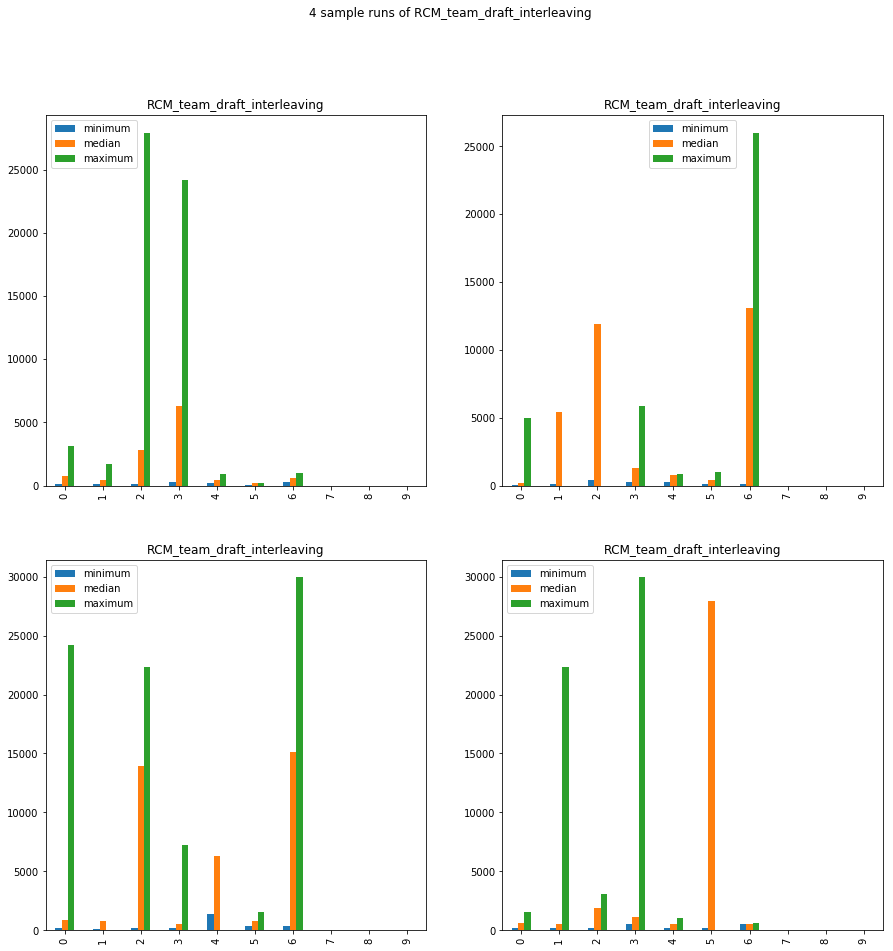

In [148]:
run_setup(model_RCM, team_draft_interleaving) 

On average, the results seem to be wildly variant for RCM, for each bin. No correlation can be calculated between bins and required samples, and no bin is preferred. As such, no correlation can be estimated.

#### Probabilistic Interleaving RCM

   minimum   median  maximum
0  115.992  141.237  1953.11
1  560.328  4977.02      inf
2  173.035  1380.62  7256.44
3  50.7864  2911.32  27934.2
4      102  399.928    29925
5  181.695  2911.32  6766.31
6  815.821  2500.49  4185.15
7      inf      inf      inf
8      inf      inf      inf
9      inf      inf      inf


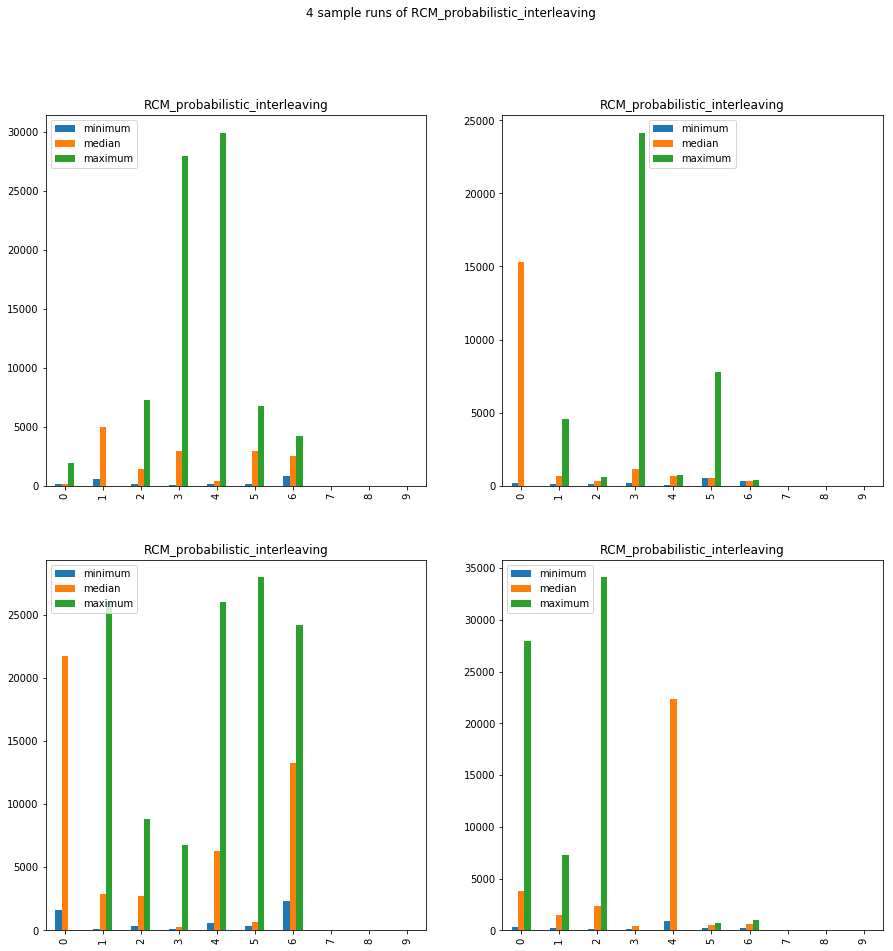

In [151]:
run_setup(model_RCM, probabilistic_interleaving)

Similar to team-draft interleaving, there does not seem to be any particular preference for bin or coherent pattern. As such, this model can indeed only be used as a baseline of comparison.